In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
import os
import fnmatch

training_labels = pd.read_csv('./g2net-gravitational-wave-detection/training_labels.csv')
l = len(training_labels)
src = './g2net-gravitational-wave-detection/train'

training_samples = l//10
testing_samples = l//20

X_train = np.empty((training_samples, 4096, 3))
y_train = np.empty((training_samples))
X_test = np.empty((testing_samples, 4096, 3))
y_test = np.empty((testing_samples))
i = 0
testing = False
for index, row in training_labels.iterrows():
    #if i % 1000 == 0:
        #print(i)
    filename = row['id']
    f1 = filename[0:1]
    f2 = filename[1:2]
    f3 = filename[2:3]
    filename = filename + '.npy'
    file = src + '/' + f1 + '/' + f2 + '/' + f3 + '/' + filename
    signals = np.load(file)
    target = row['target']
    if not testing:
        X_train[i,:,0] = signals[0]
        X_train[i,:,1] = signals[1]
        X_train[i,:,2] = signals[2]
        y_train[i] = target
    else:
        X_test[i,:,0] = signals[0]
        X_test[i,:,1] = signals[1]
        X_test[i,:,2] = signals[2]
        y_test[i] = target
    #d = {'id': i, 'H1': [signals[0]], 'L1': [signals[1]], 'V1': [signals[2]], 'target': target}
    #data.append(pd.DataFrame(d))
    i = i+1
    if i == training_samples and not testing:
        testing = True
        i = 0
    if i == testing_samples and testing:
        break

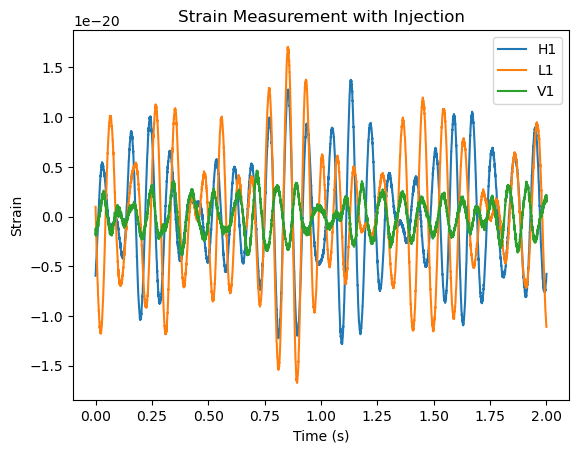

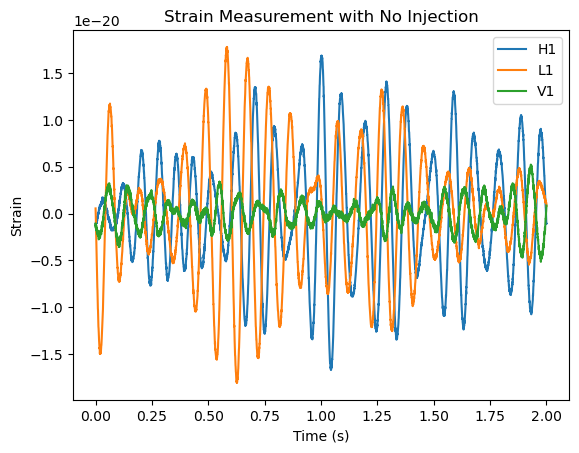

In [3]:
injH = X_train[0,:,0]
injL = X_train[0,:,1]
injV = X_train[0,:,2]

t = np.linspace(0, 2, 4096)

fig1 = plt.figure()
plt.plot(t, injH, label='H1')
plt.plot(t, injL, label='L1')
plt.plot(t, injV, label='V1')
plt.xlabel('Time (s)')
plt.ylabel('Strain') 
plt.legend()
plt.title('Strain Measurement with Injection')
plt.show()

noInjH = X_train[1,:,0]
noInjL = X_train[1,:,1]
noInjV = X_train[1,:,2]

fig2 = plt.figure()
plt.plot(t, noInjH, label='H1')
plt.plot(t, noInjL, label='L1')
plt.plot(t, noInjV, label='V1')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Strain Measurement with No Injection')
plt.legend()
plt.show()

In [4]:
X_train = X_train.reshape(-1, 4096, 1, 3)
X_test = X_test.reshape(-1, 4096, 1, 3)

In [5]:
def ResBlock(inputs, in_channels, out_channels, strides=1):
    x = layers.Conv1D(in_channels, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(out_channels, 3, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    inputs = layers.Conv1D(out_channels, kernel_size=1)(inputs)
    x = layers.Add()([inputs, x])
    return x

In [6]:
inputs = keras.Input(shape=(4096,1,3))
x = ResBlock(inputs, 3, 8)
x = ResBlock(x, 8, 8)
x = ResBlock(x, 8, 16, strides = 2)
x = ResBlock(x, 16, 16)
x = ResBlock(x, 16, 32, strides = 2)
x = ResBlock(x, 32, 32)
x = ResBlock(x, 32, 64, strides = 2)
x = ResBlock(x, 64, 64)
x = ResBlock(x, 64, 64, strides = 2)
x = ResBlock(x, 64, 64)
x = ResBlock(x, 64, 64, strides = 2)
x = ResBlock(x, 64, 64)
x = ResBlock(x, 64, 32)
x = ResBlock(x, 32, 32)
x = ResBlock(x, 32, 16)
x = ResBlock(x, 16, 16)
x = ResBlock(x, 16, 1)
outputs = layers.Softmax()(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 1, 3)]         0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 1, 3)           30        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 1, 3)           12        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 4096, 1, 3)           0         ['batch_normalization[0][0

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train,
          batch_size=1, epochs=1,
          verbose=1)

56000/56000 [==============================] - 4982s 89ms/step - loss: 7.6503 - accuracy: 0.4983


In [11]:
results = model.evaluate(X_test, y_test, batch_size=1)
print("test loss, test acc:", results)

28000/28000 [==============================] - 705s 25ms/step - loss: 7.6261 - accuracy: 0.4999
test loss, test acc: [7.626054286956787, 0.4999285638332367]
